In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone


### Prep work
set up directory with original and destination grid files in it

In [2]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [4]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx3v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid
Generating /glade/work/kristenk/esmlab-regrid/weights/latlon_1x1_180W_to_POP_gx3v7_conservative


In [5]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG        (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    ULAT         (nlat, nlon) float64 -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    ULONG        (nlat, nlon) float64 325.1 328.7 332.3 ... 318.7 320.1 321.5
    DXT          (nlat, nlon) float64 7.302e+06 7.302e+06 ... 6.129e+06
    DYT          (nlat, nlon) float64 1.686e+07 1.686e+07 ... 4.524e+06
    TAREA        (nlat, nlon) float64 1.231e+14 1.231e+14 ... 2.773e+13
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 

### Define a dictionary to translate variable names from WOA to POP and set up file paths

In [6]:
# woa_pth = '/glade/work/mclong/woa2013v2/1x1d' #this is WOA 2013
woa_pth = '/glade/work/kristenk/WOA_data/' #this is WOA 2013
pop_to_woa_vars = {'TEMP': 't_an', 'SALT': 's_an', 'NO3': 'n_an', 'O2': 'o_an', 'dO2sat': 'O_an',
                  'AOU': 'A_an', 'SiO3': 'i_an', 'PO4': 'p_an'}

In [7]:
woa_to_pop_vars = {woa: pop for pop, woa in pop_to_woa_vars.items()}

In [8]:
def woa_filename(pop_varname, month):
    woa_var_code = pop_to_woa_vars[pop_varname][0]
    
    if pop_varname in ['TEMP', 'SALT']:
        #return f'{woa_pth}/woa13_decav_{woa_var_code}{month:02d}_01v2.nc' 
        return f'{woa_pth}/woa18_decav_{woa_var_code}{month:02d}_01.nc' 
    else:
        #return f'{woa_pth}/woa13_all_{woa_var_code}{month:02d}_01.nc'
        return f'{woa_pth}/woa18_all_{woa_var_code}{month:02d}_01.nc'    

In [9]:
mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916    

### Define a function that reads in WOA annual data and fixes units & attributes

In [10]:
def open_woa_ann(pop_varname):
    
    # read annual data
    woa_var = pop_to_woa_vars[pop_varname]    
    dsann = xr.open_dataset(woa_filename(pop_varname, month=0), decode_times=False)
    attrs = dsann[woa_var].attrs

    # drop time and other vars
    dsann = dsann.isel(time=0, drop=True)      
    dsann = dsann.drop([v for v in dsann.data_vars if v != woa_var])
    
    # modify attributes
    attrs['long_name'] = (attrs['standard_name']
                          .replace('moles_concentration_of_', '')
                          .replace('_in_sea_water', ''))

    if attrs['units'] == 'micromoles_per_liter':
        attrs['units'] = 'mmol/m^3'

    # convert units for oxygen
    if pop_varname == 'O2' and attrs['units'] == 'milliliters_per_liter':
        dsann[woa_var] = dsann[woa_var] * mlperl_2_mmolm3
        attrs['units'] = 'mmol/m^3'
        attrs['long_name'] = 'Oxygen'
    
    # convert units for AOU
    if pop_varname == 'AOU' and attrs['units'] == 'milliliters_per_liter':
        dsann[woa_var] = dsann[woa_var] * mlperl_2_mmolm3
        attrs['units'] = 'mmol/m^3'
        attrs['long_name'] = 'Apparent Oxygen Utilization'
    
    # remove unneeded attrs
    del attrs['standard_name'] 
    del attrs['cell_methods']
    del attrs['grid_mapping']    
        
    dsann[woa_var].attrs = attrs
   
    # return dataset with POP names
    return dsann.rename({k: v for k, v in woa_to_pop_vars.items() if k in dsann.data_vars})

### Use the function to get annual WOA data

In [11]:
varlist = ['TEMP', 'SALT', 'NO3', 'O2', 'SiO3', 'PO4','AOU']

ds_list = []
for v in varlist:
    dsi = open_woa_ann(v)
    ds_list.append(dsi)
ds_woa = xr.merge(ds_list)
ds_woa

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
Data variables:
    TEMP     (depth, lat, lon) float32 ...
    SALT     (depth, lat, lon) float32 ...
    NO3      (depth, lat, lon) float32 ...
    O2       (depth, lat, lon) float32 ...
    SiO3     (depth, lat, lon) float32 ...
    PO4      (depth, lat, lon) float32 ...
    AOU      (depth, lat, lon) float32 ...

In [12]:
ds_woa.depth

<xarray.DataArray 'depth' (depth: 102)>
array([0.00e+00, 5.00e+00, 1.00e+01, 1.50e+01, 2.00e+01, 2.50e+01, 3.00e+01,
       3.50e+01, 4.00e+01, 4.50e+01, 5.00e+01, 5.50e+01, 6.00e+01, 6.50e+01,
       7.00e+01, 7.50e+01, 8.00e+01, 8.50e+01, 9.00e+01, 9.50e+01, 1.00e+02,
       1.25e+02, 1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02, 2.50e+02, 2.75e+02,
       3.00e+02, 3.25e+02, 3.50e+02, 3.75e+02, 4.00e+02, 4.25e+02, 4.50e+02,
       4.75e+02, 5.00e+02, 5.50e+02, 6.00e+02, 6.50e+02, 7.00e+02, 7.50e+02,
       8.00e+02, 8.50e+02, 9.00e+02, 9.50e+02, 1.00e+03, 1.05e+03, 1.10e+03,
       1.15e+03, 1.20e+03, 1.25e+03, 1.30e+03, 1.35e+03, 1.40e+03, 1.45e+03,
       1.50e+03, 1.55e+03, 1.60e+03, 1.65e+03, 1.70e+03, 1.75e+03, 1.80e+03,
       1.85e+03, 1.90e+03, 1.95e+03, 2.00e+03, 2.10e+03, 2.20e+03, 2.30e+03,
       2.40e+03, 2.50e+03, 2.60e+03, 2.70e+03, 2.80e+03, 2.90e+03, 3.00e+03,
       3.10e+03, 3.20e+03, 3.30e+03, 3.40e+03, 3.50e+03, 3.60e+03, 3.70e+03,
       3.80e+03, 3.90e+03, 4.00e+03,

### Regrid laterally

/glade/work/kristenk/miniconda/envs/analysis2/lib/python3.7/site-packages/esmlab_regrid/core.py:203: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)


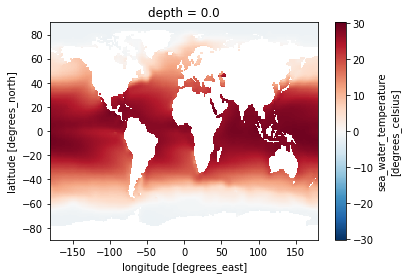

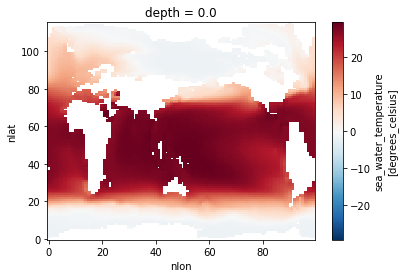

In [13]:
dso_lateral = xr.Dataset()
for v in varlist:
    dso_lateral[v] = regrid_operator(ds_woa[v], renormalize=True)  #, apply_mask=True) #commented out apply_mask (get an error)
    dso_lateral[v].attrs = ds_woa[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

dso_lateral.depth.data = dso_lateral.depth.data * 1e2
dso_lateral.depth.attrs['units'] = 'cm'

plt.figure()
ds_woa[varlist[0]].isel(depth=0).plot()

plt.figure()
dso_lateral[varlist[0]].isel(depth=0).plot();

### Regrid vertically

In [14]:
dso_lat_vert = xr.Dataset()

dim = 'depth'
new_coord = ds_dst.z_t
for v in varlist:
    da = dso_lateral[v]
    dso_lat_vert[v] = da.interp(coords={dim: new_coord},
                                method='linear',
                                assume_sorted=True,
                                kwargs={'bounds_error': False})
    dso_lat_vert[v] = xr.where(np.isclose(dso_lat_vert[v], 0., atol=1e-10), 0., 
                               dso_lat_vert[v])
    dso_lat_vert[v].attrs = dso_lateral[v].attrs
    
dso_lat_vert = dso_lat_vert.drop([dim])
dso_lat_vert

<xarray.Dataset>
Dimensions:  (nlat: 116, nlon: 100, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    AOU      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

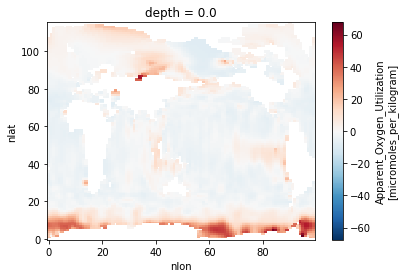

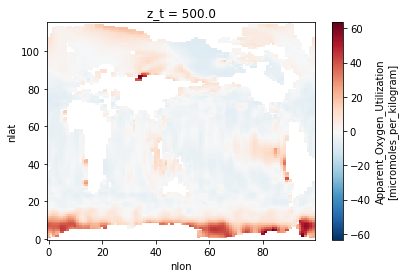

In [15]:
plt.figure()
dso_lateral[varlist[-1]].isel(depth=0).plot()

plt.figure()
dso_lat_vert[varlist[-1]].isel(z_t=0).plot();

### Apply missing values mask to the newly interpolated data
First make a mask

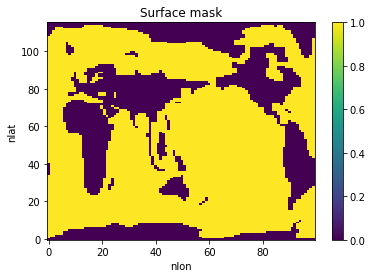

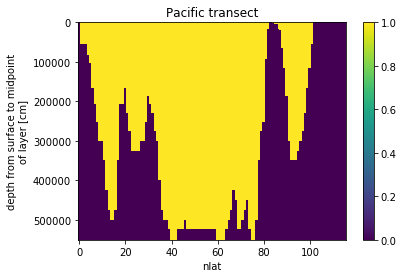

In [18]:
nk = len(ds_dst.z_t)
nj, ni = ds_dst.KMT.shape

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_dst.KMT)
MASK = xr.where(MASK.notnull(), True, False)

MASK['z_t'] = ds_dst.z_t

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')


Then apply the mask

In [19]:
for v in varlist:   
    dso_lat_vert[v] = dso_lat_vert[v].where(MASK)

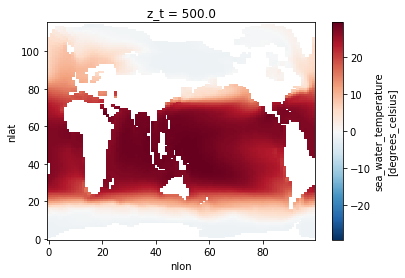

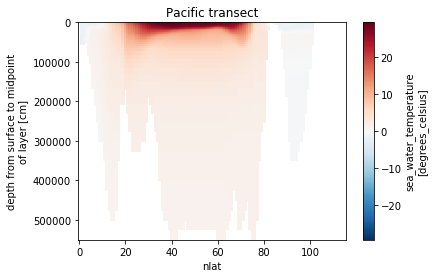

In [21]:
plt.figure()
dso_lat_vert[varlist[0]].isel(z_t=0).plot()

plt.figure()
dso_lat_vert[varlist[0]].isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')

### Lateral smoothing operation

In [22]:
# loop over variables
dso_smooth = xr.Dataset()
for v in varlist:    
    
    # apply lateral smooth
    dso_smooth[v] = pop_tools.lateral_fill(dso_lat_vert[v].copy(), MASK, ltripole=ltripole)
    dso_smooth[v].attrs = dso_lat_vert[v].attrs
    
    # perform vertical fill if necessary
    unfilled = dso_smooth[v].isnull() & (MASK == 1.)                    
    if not unfilled.any():
        continue   
    for k in range(1, ds_dst.z_t.shape[0]):
        dso_smooth[v][k, :, :] = xr.where(unfilled[k, :, :], 
                                          dso_smooth[v][k-1, :, :], 
                                          dso_smooth[v][k, :, :])
        
    if (dso_smooth[v].isnull() & (MASK == 1.)).any():
        warnings.warn(f'{v} still has missing values')
    
dso_smooth

<xarray.Dataset>
Dimensions:  (nlat: 116, nlon: 100, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    AOU      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

### Get the dataset ready to write out

In [23]:
dso = dso_smooth.copy()

for v in dso.variables:
    dso[v].encoding['_FillValue'] = default_fillvals['f4']
    dso[v].encoding['dtype'] = np.float32
    if dso.NO3.dims == {'z_t', 'nlat', 'nlon'}:
        dso[v].attrs['coordinates'] = 'TLONG TLAT z_t'
    
for v in ds_dst.variables:
    dso[v] = ds_dst[v]
    
for v in dso.variables:
    if '_FillValue' not in dso[v].encoding:
        dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP         (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SALT         (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    NO3          (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    O2           (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SiO3         (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    PO4          (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    AOU          (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    TLAT         (nlat, nlon) float64 -79.5 -79.5

In [25]:
#!ncdump -h /glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc

In [26]:
#file_out = f'{config.dirout}/marbl_jan_ic_woa_{dst_grid}.c{datestamp}.nc'
file_out = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_x3POPgrid.nc'
dso.to_netcdf(file_out)